# **Определение возраста покупателей**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека.

Загрузка необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Исследовательский анализ данных

**Задание**

 - Посмотрить на размер выборки;
 - Построить график распределения возраста в выборке;
 - Напечатать на экране 10–15 фотографий и посмотрить, как устроен датасет;
 - Сделать выводы о том, как результаты исследования повлияют на обучение модели.

## Загрузка исходных данных

Запишим пути и названия файлов в системе

In [3]:
root_folder = '/datasets/faces/'
images_folder = root_folder + 'final_files/'
file_name = 'labels.csv'

CSV-файл labels.csv с двумя колонками: file_name и real_age

In [4]:
labels = pd.read_csv(root_folder+file_name)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет, всего 7591 файл с изображениями

In [5]:
labels.sample(5).T

,1953,3959,6740,1241,1352
file_name,001953.jpg,003959.jpg,006747.jpg,001241.jpg,001352.jpg
real_age,32,38,13,14,44


Структура таблицы: 
   - название файла с картинкой "file_name";
   - возраст человека на картинке.

Проверим наличие полных дубликатов и отдельно на наличие повторяющихся файлов(по названию)

In [6]:
labels['file_name'].duplicated().sum()

0

Дубликатов нет

## Анализ данных

Посмотрим распределение "клиентов" по возрасту

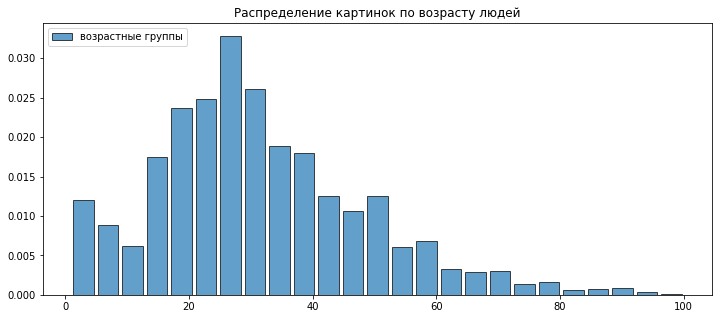

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.hist(labels['real_age'], bins =25, alpha=0.7, rwidth=0.85, label='возрастные группы', edgecolor='black', density = True)
ax.set_title('Распределение картинок по возрасту людей')
ax.legend(loc='upper left')
plt.subplots_adjust(wspace=0.5) 
plt.show()
labels['real_age'].describe()

- В данных представлены граждане от 1 года до 100 лет;
- Медиана на 29 годах (среднее 31.2);
- Не обладая специальными знаниями в области социологии, можно было бы только отметить, что хорошо бы распределение повторяло распределение людей по возрастным группам "нашего" населенного пункта. Но если говорить поверхностно - хорошо что большинство фотографий находится в диапазоне 17-70 лет это вероятно наши основные клиенты.

Рассмотрим сами файлы фотографий и постараемся проанализировать содержание и данные.

Используем ImageDataGenerator для загрузки изображений из папки. Хотя функционал широк и позволяет работать с исходными изображениями для генерации новых (поворот, масштабирование, смещение и т.д.) здесь просто загрузим.

In [8]:
datagen = ImageDataGenerator()

Смасштабируем изображения в размер 224x224

In [12]:
%%time
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=images_folder,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.
CPU times: user 446 ms, sys: 290 ms, total: 735 ms
Wall time: 1min 26s


Раскидаем datagen_flow на признак и изображения

In [10]:
features, target = next(datagen_flow)
features.shape

(16, 224, 224, 3)

Можно отметить, что изображения цветные 3 канала - RGB. Размер изображения 224x224

Отобразим первые 16 изображений на экране (все таки пришлось поделить на 255 🤪)

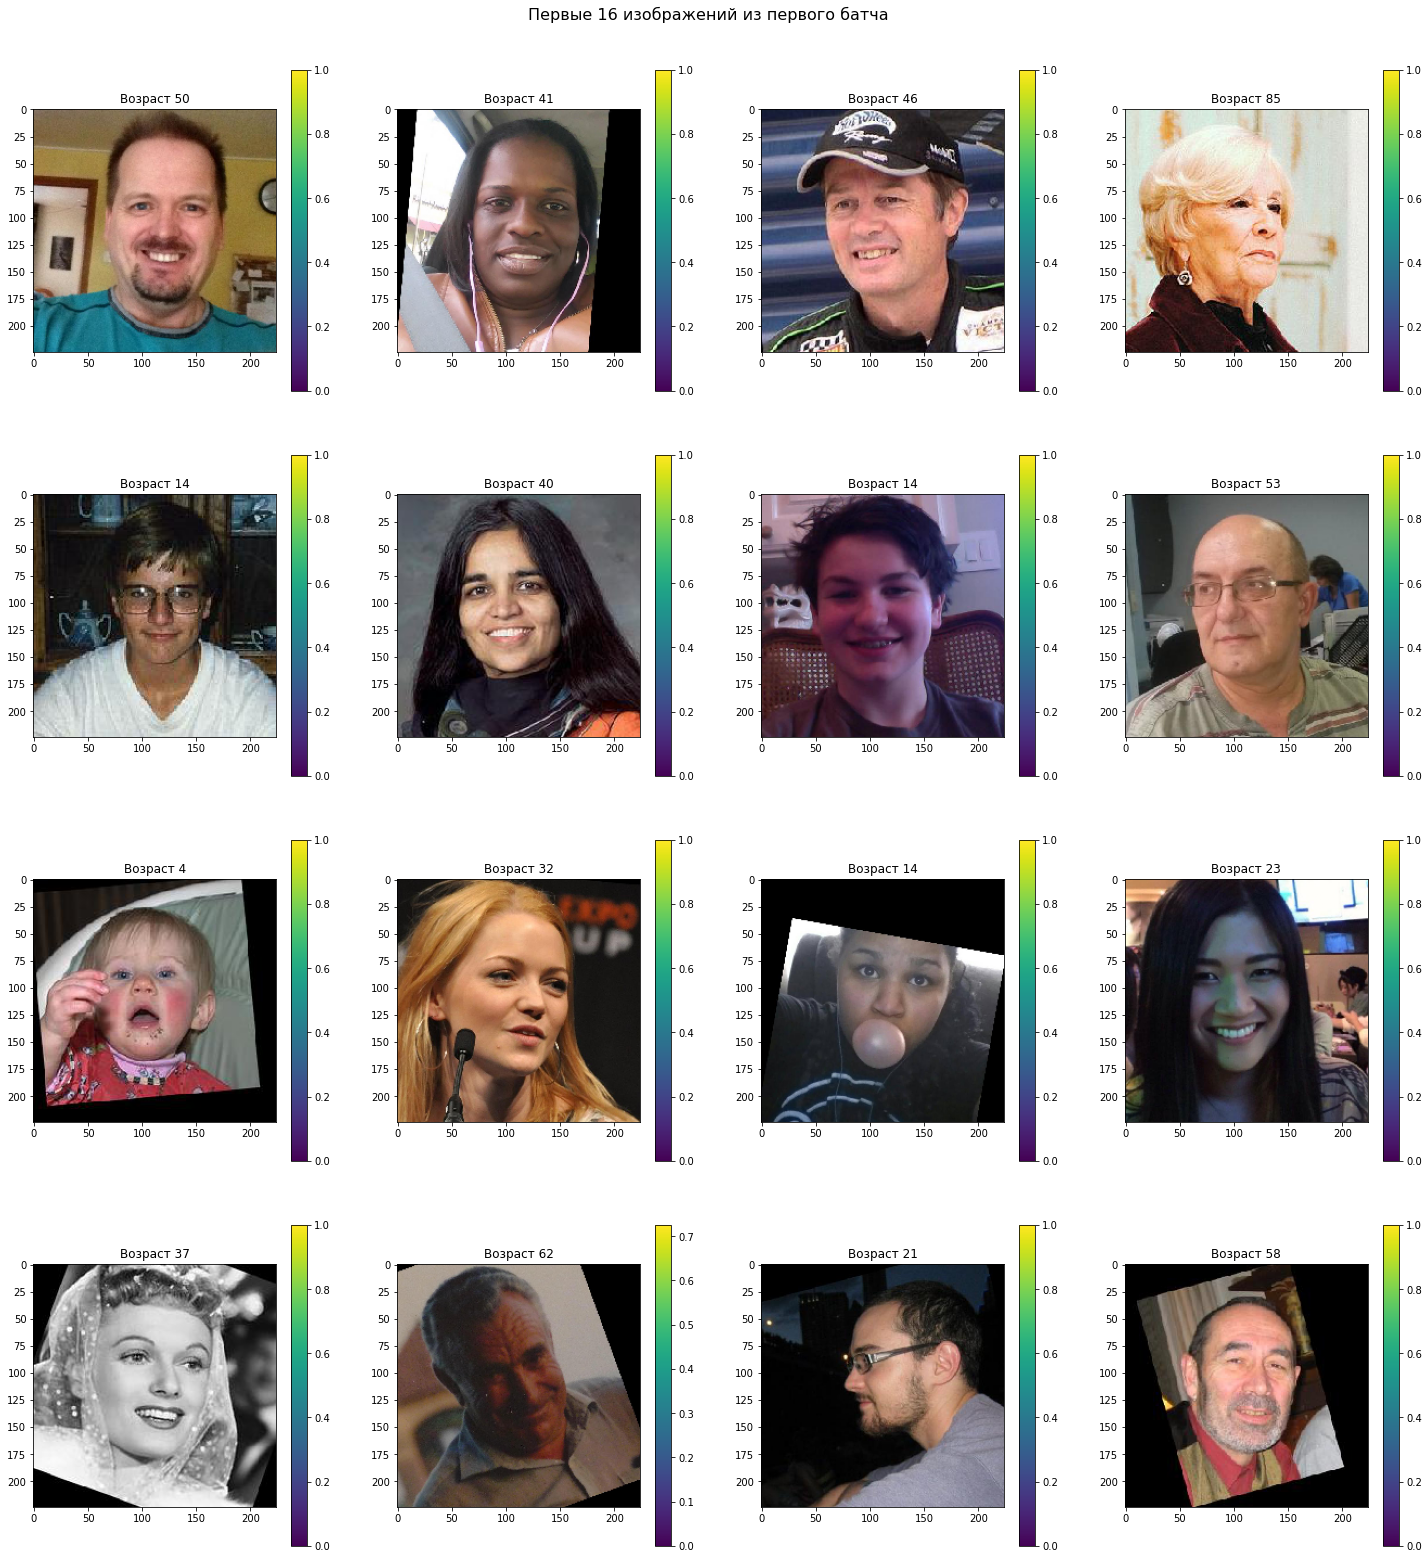

In [11]:
fig = plt.figure(figsize=(25,25))
fig.suptitle('Первые 16 изображений из первого батча', fontsize=16)
fig.subplots_adjust(top = 0.945)
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i]/255)
    plt.colorbar()
    plt.title("Возраст " + str(target[i]))
plt.show()

 - На выведенных фото изображены люди разных возрастов;
 - Среди людей, есть как пожилые люди, так и маленькие дети;
 - Фото могут быть как цветными, так и чб;
 - Некоторые фото повернуты, либо отражены - скорее всего нет необходимости дополнительно поворачивать изображения при загрузке;
 - На фото изображены преимущественно плечевые портреты, либо анфас либо поворот головы 3/4.

**Выводы:**

1. Вероятность того, что кто то из граждан когда либо посещал пятерочку, магнит или перекресток стремится к 0. Для работы с клиентами  желательно конечно использовать локализованные данные (но их вероятно достать сложно, если не провести акцию "получи леденец и скажи свой возраст");
2. Размер выборки составляет 7591 фото. Распределение возраста в выборке близко нормальному, среднее составляет 31.20,  медиана - 29, стандартное отклонение - 17.14;
3. Для увеличения размера обучающей выборки возможно использовать аугментацию: масштабирование, отражение по горизонтали/вертикали, сдвиг. При этом поворот вероятно уже был использован и эффективность каждого из методов целесообразно отдельно проверить;
4. Для подачи в нейронную сеть будем использовать ImageDataGenerator с параметрами 32х224х224х3, где 16 - количество изображений, 224х224 - это количество пикселей ШхД, 3 - количество каналов(RGB). Значения каналов в пикселе будет лежать в диапазоне от 0 до 1, так как собираемся нормировать данные при выгрузке;
5. Для предсказания используем предобученной сверточная нейросеть типа ResNet50.

## Обучение модели

Код обучения модели

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split = 0.25,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    rescale = 1. / 255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
                                  validation_split = 0.25,
                                  rescale = 1. / 255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    weights = 'imagenet'
    body = ResNet50(input_shape=input_shape,
                    weights=weights,
                    include_top=False)
    model = Sequential()
    model.add(body)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

Результат вывода на экран

```
Train for 356 steps, validate for 119 steps
Epoch 1/25
2024-03-26 13:41:13.657014: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-03-26 13:41:13.962600: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 100s - loss: 210.3214 - mae: 10.4906 - val_loss: 481.1251 - val_mae: 16.8062
Epoch 2/25
356/356 - 92s - loss: 92.8337 - mae: 7.2857 - val_loss: 127.9659 - val_mae: 8.4655
Epoch 3/25
356/356 - 92s - loss: 68.0712 - mae: 6.3556 - val_loss: 84.1750 - val_mae: 6.8399
Epoch 4/25
356/356 - 92s - loss: 52.7314 - mae: 5.6118 - val_loss: 84.7816 - val_mae: 6.8783
Epoch 5/25
356/356 - 92s - loss: 41.1296 - mae: 4.9745 - val_loss: 90.5353 - val_mae: 6.8871
Epoch 6/25
356/356 - 92s - loss: 34.3640 - mae: 4.5520 - val_loss: 75.0909 - val_mae: 6.4666
Epoch 7/25
356/356 - 93s - loss: 28.1189 - mae: 4.1095 - val_loss: 74.4690 - val_mae: 6.5663
Epoch 8/25
356/356 - 93s - loss: 24.4657 - mae: 3.8147 - val_loss: 84.5417 - val_mae: 6.9143
Epoch 9/25
356/356 - 92s - loss: 22.4563 - mae: 3.6595 - val_loss: 77.6078 - val_mae: 6.5729
Epoch 10/25
356/356 - 94s - loss: 18.5877 - mae: 3.3436 - val_loss: 76.7046 - val_mae: 6.7212
Epoch 11/25
356/356 - 92s - loss: 18.7753 - mae: 3.3430 - val_loss: 64.8628 - val_mae: 6.0093
Epoch 12/25
356/356 - 93s - loss: 16.4748 - mae: 3.1240 - val_loss: 76.8056 - val_mae: 6.7540
Epoch 13/25
356/356 - 92s - loss: 16.5112 - mae: 3.0877 - val_loss: 69.0242 - val_mae: 6.0776
Epoch 14/25
356/356 - 92s - loss: 15.4013 - mae: 2.9972 - val_loss: 84.6083 - val_mae: 6.7322
Epoch 15/25
356/356 - 92s - loss: 13.1717 - mae: 2.7857 - val_loss: 72.0785 - val_mae: 6.3758
Epoch 16/25
356/356 - 92s - loss: 14.0270 - mae: 2.8838 - val_loss: 73.1899 - val_mae: 6.2403
Epoch 17/25
356/356 - 92s - loss: 15.4794 - mae: 3.0091 - val_loss: 74.5995 - val_mae: 6.3446
Epoch 18/25
356/356 - 92s - loss: 12.8583 - mae: 2.7509 - val_loss: 69.6494 - val_mae: 6.1537
Epoch 19/25
356/356 - 92s - loss: 10.5724 - mae: 2.4903 - val_loss: 67.1664 - val_mae: 6.0150
Epoch 20/25
356/356 - 92s - loss: 10.3635 - mae: 2.4737 - val_loss: 69.4630 - val_mae: 6.3515
Epoch 21/25
356/356 - 92s - loss: 10.2535 - mae: 2.4365 - val_loss: 64.9551 - val_mae: 6.0859
Epoch 22/25
356/356 - 92s - loss: 10.8052 - mae: 2.4982 - val_loss: 69.3670 - val_mae: 6.1631
Epoch 23/25
356/356 - 93s - loss: 11.1701 - mae: 2.5480 - val_loss: 65.8465 - val_mae: 6.0214
Epoch 24/25
356/356 - 92s - loss: 9.6030 - mae: 2.3883 - val_loss: 63.5581 - val_mae: 5.7643
Epoch 25/25
356/356 - 92s - loss: 10.0743 - mae: 2.4026 - val_loss: 64.7073 - val_mae: 5.9019
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 64.7073 - mae: 5.9019
Test MAE: 5.9019

```

## Анализ обученной модели

* Проведен исследовательский анализ данных - размер изображения - 16x224х224х3, где 3 - количество каналов, а 16 размер батча .
* Записан код обучения модели, состоящий из:
        * функции загрузки обучающей выборки
        * функции загрузки тестовой выборки
        * кода модели
        * кода обучения модели
* В качестве модели выбрана ResNet50, для которой отключены верхние полносвязные слои. При инициализации в качестве весов взяты веса `imagenet`. Модель дополнена слоем `GlobalAveragePooling2D()`, а также полносвязным слоем с 1 нейроном и функцией активации `relu`. В качестве функции потерь выбрана `mean_squared_error`, оптимизатор - Adam() с 0,0001. Метрика `mae`. 
* Количество эпох обучения 25. 
* К 3-ой эпохе значение метрики на тестовой выборке достигает 6,83 , а фунции потерь на тестовой выборке - 84.17 и удовлетворяет условию выполнения задачи MAE < 8;
* Были выключены все преобразования кроме смещения и масштабирования. Таким образом предположение, что изображения изначально включали в себя преобразованные косвенно подтвердилось.


## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы